## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Deep Learning - Generative Adversarial Networks

In this exercise we will build a GAN using the MNIST dataset. If everything goes well and you're able to train the GAN correctly, you should be able to generate handwritten digits that never existed before, though it may require a lot of hyperparameter experimentation and lengthy training times to get high-quality images.

In [61]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Reshape, Input
from tensorflow.keras import Model, Sequential

import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

np.random.seed(0)
tf.get_logger().setLevel('ERROR')  # Don't display tensorflow warnings

In [63]:
# Load the MNIST data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_shape = list(x_train[0].shape)
print(img_shape)

[28, 28]


In [64]:
# Set some hyperparameters

latent_dim = 100  # This is the dimension of the random noise we'll use for the generator
batch_size = 128
n_train_steps = 1000  # We'll specify number of training steps (batches) rather than number of epochs

## Build the Generator model

The generator takes in a latent vector and outputs a 2D image. Below, you'll build a model with three hidden Dense layers and a Dense output layer. The final output is then Reshape'd to the image size.

We haven't discussed [BatchNorm layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) much, if at all, but we'll include a BatchNorm layer after each hidden Dense layer. BatchNorm layers do a batch-by-batch normalization of the data, which can greatly accelerate training convergence.

In [68]:
# Create a list of layers that specify the architecture of the generator, 
# and name that list "generator_layers".
#
# Think about what the input to the generator is and what the output should be...
#
# Your model should take in a latent vector, process it with three hidden Dense layers
# with number of nodes and activation of your chosing (try starting with 100 nodes
# per layer and ReLU activation). After each hidden layer, add a BatchNormalization layer.
# A final (additional) output Dense layer should have activation function that
# maintains values between -1 and 1 (the range of "pixel" values).
# Finalize the list of layers with a Reshape layer to get it to the correct image size.

# YOUR CODE HERE
generator_layers = [
                    tf.keras.layers.Dense(128*7*7, input_dim=latent_dim),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(100, activation='relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(100, activation='relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(28*28, activation='tanh'),
                    tf.keras.layers.Reshape((28,28))]

generator = Sequential(generator_layers)
generator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 6272)              633472    
                                                                 
 batch_normalization_12 (Bat  (None, 6272)             25088     
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 100)               627300    
                                                                 
 batch_normalization_13 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_38 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_14 (Bat  (None, 100)            

In [69]:
assert generator
assert len(generator_layers) == 8
assert isinstance(generator_layers[0], Dense)
assert isinstance(generator_layers[2], Dense)
assert isinstance(generator_layers[4], Dense)
assert isinstance(generator_layers[6], Dense)
assert isinstance(generator_layers[1], BatchNormalization)
assert isinstance(generator_layers[3], BatchNormalization)
assert isinstance(generator_layers[5], BatchNormalization)

## Build the discriminator model

In [70]:
# Create a list of layers for the discriminator model and name it "discriminator_layers"
#
# Think about what the input and output for a discriminator model are...
#
# The discriminator model should have two Dense layers.
# You can chose the number of neurons in each layer. 512 and 256 for the first
# and second layers, respectively, are reasonable starting points.
# Add the appropriate output layer and activation function.

# YOUR CODE HERE
# discriminator_layers = [
#                         tf.keras.layers.Flatten(input_shape=(28,28,1)),
#                         tf.keras.layers.Dense(512, input_shape=img_shape, activation='tanh'),
#                         tf.keras.layers.Dense(256),
#                         tf.keras.layers.Dense(1, activation='sigmoid')
# ]
discriminator_layers = [
                        tf.keras.layers.Flatten(input_shape=(28,28,1)),
                        tf.keras.layers.Dense(512, activation='tanh'),
                        tf.keras.layers.Dense(256),
                        tf.keras.layers.Dense(1, activation='sigmoid')
]

discriminator = Sequential(discriminator_layers)
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_40 (Dense)            (None, 512)               401920    
                                                                 
 dense_41 (Dense)            (None, 256)               131328    
                                                                 
 dense_42 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [71]:
assert discriminator
assert len(discriminator_layers) == 4

## Assemble the entire GAN

Training GANs is a bit more complex than other networks so the below code is provided for you as is. You may reuse this code for your own edification but are not expected to have figured it out on your own.

You are also likely to not be able to get good results in the time allocated for this exercise. Although you might if you try a variety of hyperparameters and let your models train for quite some time.

In [72]:
discriminator.compile(loss='binary_crossentropy',optimizer="adam", metrics=['accuracy'])

# The generator takes noise as input and generates images
z = Input(shape=(latent_dim,))
img_fake = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity ("realness")
realness = discriminator(img_fake)

combined = Model(z, realness)
combined.compile(loss='binary_crossentropy', optimizer="adam")

In [73]:
# Rescale image data to [-1, 1]
x_train = x_train / 127.5 - 1.

# Ground truth labels
labels_real = np.ones((batch_size, 1))
labels_fake = np.zeros((batch_size, 1))

## Training

The code below trains the GAN by alternating between updates to the discriminator and updates to the generator. In the plots that are created during ongoing training, observe the generated images and the losses of both models. At some points during training you might see example of mode collapse--as indicated by many or all the generated images looking like the same (noisy) number (or shape).

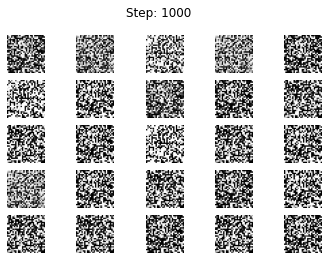

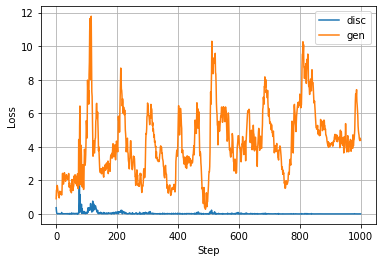

Trained for 1000 steps in 156.8 seconds.


In [74]:
loss_history_disc = []
loss_history_gen = []

rows, cols = 5, 5  # Number of subplot rows and columns

t_start = time.time()
for step in range(n_train_steps):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate a batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    discriminator.trainable = True
    loss_disc_real, acc_disc_real = discriminator.train_on_batch(imgs, labels_real)
    loss_disc_fake, acc_disc_fake = discriminator.train_on_batch(gen_imgs, labels_fake)
    loss_disc = (loss_disc_real + loss_disc_fake) / 2
    loss_history_disc.append(loss_disc)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator (push the discriminator to predict fake images as real)
    discriminator.trainable = False
    loss_gen = combined.train_on_batch(noise, labels_real)
    loss_history_gen.append(loss_gen)
    
    if step%50==0 or step==n_train_steps-1:
        clear_output(wait=True)
        
        noise = np.random.normal(0, 1, (rows*cols, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images to [0, 1] for plotting
        gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure(1)
        plt.clf()
        cnt = 0
        for i_row in range(rows):
            for j_col in range(cols):
                plt.subplot(rows, cols, cnt+1)
                plt.imshow(gen_imgs[cnt], cmap='gray')
                plt.axis('off')
                cnt += 1
        plt.suptitle(f"Step: {step+1}")
        
        plt.figure(2)
        plt.clf()
        plt.plot(loss_history_disc, label='disc')
        plt.plot(loss_history_gen, label='gen')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.show()
        
        print(f'Trained for {step+1} steps in {time.time()-t_start:0.1f} seconds.')

## Losses

Note that the losses of the generator and discriminator oscillate, and do not generally decrease across training, unlike training losses we've observed in the past. This is because the generator and discriminator are battling against one another, never allowing the other to get the upper hand. Nonetheless, both models are learning, as we can see by the subjective improvement of the fake images over the training period.

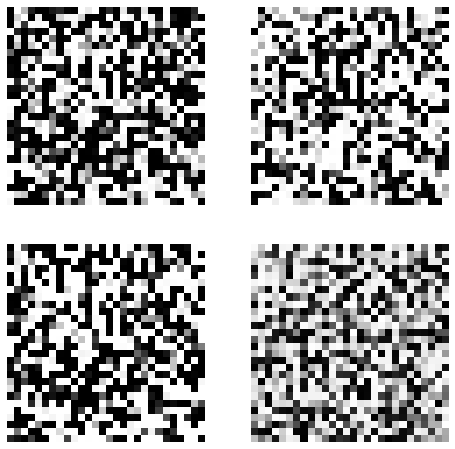

In [79]:
# Generate and display a few more fake digits

plt.figure(figsize=(8, 8))
noise = np.random.normal(0, 1, (4, latent_dim))
gen_img = generator.predict(noise)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(gen_img[i], cmap='gray')
    plt.axis('off')

## Feedback

In [ ]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    # YOUR CODE HERE
    return 'My code very obviously does nothing useful, but passes all of the asserts, IDK.'